Este código plota a região de abrangência de um radar. Como exemplo são plotados os radares:

- São Francisco (MG)
- Almenara (MG)
- Sta Tereza (ES)
- Salvador (BA)
- Três Marias (MG)

São plotados também o mapa de releveo e alguns desastres naturais que ocorreram em dezembro de 2021. Os dados de desastres naturais são provenientes do CEMADEN.



# **1° Passo:** Instalando as bibliotecas

In [1]:
# Instalando o proplot (usado para gerar Mapas também)
!pip install -q proplot

# Instalando o cartopy (usado para gerar Mapas)
!pip uninstall shapely --yes
!pip install -q shapely cartopy --no-binary shapely --no-binary cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical

Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
--2023-06-26 23:35:01--  https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6332 (6.2K) [text/plain]
Saving to: ‘cartopy_feature_download.py.1’

cartopy_feature_dow 100%[===================>]   6.18K  --.-KB/s    in 0s      

2023-06-26 23:35:01 (36.9 MB/s) - ‘cartopy_feature_download.py.1’ saved [6332/6332]

Feature physical, coastline, 110m length: 134
Feature physical, coastline, 50m length: 1428
Feature physical, coastline, 10m length: 4133
Feature physical, land, 110m length: 127
Feature physical, land, 50m length: 1420
Feature physical, land, 10m length: 

Chegando aqui, será necessário fazer a tediosa **Reinicialização do Ambiente de Execução** (acessar *Ambiente de execução* que esta na barra de ferramentas e clicar em *Reiniciar Ambiente de Execução* e rodar novamente a célula anterior de instalações) e ter que instalar todos os pacotes de novo. Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab, então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual do curso.

In [2]:
# Instalando o Salem (usado para mascarar regiões)
!pip install -q rasterio
!pip install -q pyproj

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 33.7 MB/s eta 0:00:00


# **2° Passo:** Monta Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# caminho da pasta do código
dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/6_RADAR/5_Mapa_radares/'

# **3° Passo:** Download de informações auxiliares

In [7]:
# Baixando shapefiles
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
print('\n')

# Descomprimindo shapefiles
!unzip -o /content/br_unidades_da_federacao.zip
print('\n')

--2023-06-26 23:36:39--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2019/Brasil/BR/br_unidades_da_federacao.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10912177 (10M) [application/zip]
Saving to: ‘br_unidades_da_federacao.zip’

br_unidades_da_fede 100%[===================>]  10.41M  6.04MB/s    in 1.7s    

2023-06-26 23:36:41 (6.04 MB/s) - ‘br_unidades_da_federacao.zip’ saved [10912177/10912177]



Archive:  /content/br_unidades_da_federacao.zip
 extracting: BR_UF_2019.cpg          
  inflating: BR_UF_2019.dbf          
  inflating: BR_UF_2019.prj          
  inflating: BR_UF_2019.shp          
  inflating: BR_UF_2019.shx          




# **4° Passo:** Importando as bibliotecas

In [8]:
import numpy as np                          # Biblioteca para trabalhar com matrizes
import proplot as pplt                      # Biblioteca para gerar figuras
import os                                   # Biblioteca para acessar o sistema operacional
import cartopy.crs as ccrs                  # Biblioteca para trabalhar com projeções de mapas
import cartopy.io.shapereader as shpreader  # Biblioteca para ler arquivos shapefiles
import xarray as xr
import rasterio as rio                      # Biblioteca para trabalhar com arquivos raster
import pandas as pd
import matplotlib.pyplot as plt

# vamos ignorar vários avisos
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


# **5° Passo:** Declarando funções

In [9]:
#-----------------------------------------------------------------------------------
#  Função que plota circulos de distância em geral
#-----------------------------------------------------------------------------------
def evm_plota_aneis_em_geral(aneis, lon_r, lat_r, color, label):

    """
    Retorna círculos de distância centrado no radar

    Parâmetros de entrada:
                aneis (lista): tamanho do raio do círculo em km
                lon_r (float): valor da longitude do centro do círculo em graus
                lat_r (float): valor da latitude do centro do círculo em graus
                color (str): cor do raio do círculo
                label (str): legenda

    Parâmetros de saída:
                latitude e longitude que delimita círculos de distância centrado no radar e plota os círculos
    """

    import geopy
    from geopy import distance

    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((len(aneis), 361))
    lats = np.zeros((len(aneis), 361))
    for i, dis in enumerate(aneis):
        xpts = []
        ypts = []
        for az in range(361):
            destination = distance.distance(kilometers=dis).destination(origin, az)
            lat2, lon2 = destination.latitude, destination.longitude
            xpts.append(lon2)
            ypts.append(lat2)
        lons[i,:] = xpts[:]
        lats[i,:] = ypts[:]

    for i, anel in enumerate(aneis):
        ax.plot(lons[i,:], lats[i,:], color=color, label= label, linestyle='-')

#-----------------------------------------------------------------------------------
# Função que plota os Estados
#-----------------------------------------------------------------------------------
def evm_plot_states(shapefile, cor, espessura_linha):

    """
    Retorna a plotagem dos contornos de um shapefile na figura

    Parâmetros de entrada:
                shapefile (shp): shapefile da regiao

    Parâmetros de saída:
                figura com o contorno da região baseado no shapefile fornecido
    """
    import cartopy.crs as ccrs
    import cartopy.io.shapereader as shpreader
    import matplotlib.pyplot as plt

    shapefile = list(shpreader.Reader(shapefile).geometries())
    ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor=cor,facecolor='none', linewidth=espessura_linha)

#-----------------------------------------------------------------------------------
# Função que plota as siglas
#-----------------------------------------------------------------------------------
def plot_siglas_statesb():

    color = 'gray'

    ax.annotate('RS', xy=(-54.0, -30.0),fontsize=15, color=color)
    ax.annotate('SC', xy=(-51.2, -27.5), fontsize=15, color=color)
    ax.annotate('PR', xy=(-52.0, -25.0), fontsize=15, color=color)
    ax.annotate('SP', xy=(-49.0, -22.5), fontsize=15, color=color)
    ax.annotate('MG', xy=(-46.1, -21.0), fontsize=15, color=color)
    ax.annotate('MS', xy=(-55.0, -21.0), fontsize=15, color=color)

    ax.annotate('Atlantic Ocean', xy=(-47.3, -26.0), fontsize=18, color=color)
    ax.annotate('Paraguay', xy=(-59.5, -24.0), fontsize=18, color=color)
    ax.annotate('Argentina', xy=(-60.1, -28.5), fontsize=18, color=color)
    ax.annotate('Uruguay', xy=(-57.5, -33.0), fontsize=18, color=color)

#**PARTE 1:** Lendo arquivo de desastres naturais

In [10]:
# localização dos radares
lon_radar_almenara, lat_radar_almenara = -40.67425, -16.20203
lon_radar_statereza, lat_radar_statereza = -40.5794, -19.98887
lon_radar_saofrancisco, lat_radar_saofrancisco = -44.7061, -15.9930
lon_radar_tresmarias, lat_radar_tresmarias = -45.4546, -18.1798
lon_radar_salvador, lat_radar_salvador = -38.3313, -12.8761

# define os limites da imagem
latmin, latmax, lonmin, lonmax = -23, -10.0, -49.0, -35.0

In [11]:
# leitura do arquivo de desastres naturais do CEMADEN
df = pd.read_excel(f'{dir}input/BA_MG_12_2021.xlsx')
df

,item,data,lat,lon,municipio,uf,tipo
0,1,24/12/2021,-13.226212,-39.508241,MUTUÍPE,BA,Deslizamento
1,2,25/12/2021,-14.784343,-39.266165,ITABUNA,BA,Inundação
2,3,25/12/2021,-14.788950,-39.277190,ITABUNA,BA,Inundação
3,4,25/12/2021,-13.749807,-39.486927,GANDU,BA,Inundação
4,5,25/12/2021,-13.739072,-39.487309,GANDU,BA,Inundação
5,6,25/12/2021,-13.750661,-39.496515,GANDU,BA,Inundação
6,7,26/12/2021,-13.527309,-39.966792,JAGUAQUARA,BA,Alagamento
7,8,26/12/2021,-13.527236,-39.969931,JAGUAQUARA,BA,Alagamento
8,9,26/12/2021,-13.513555,-39.961825,JAGUAQUARA,BA,Alagamento
9,10,25/12/2021,-14.748058,-39.196607,ILHÉUS,BA,Alagamento


In [12]:
# verificando o tipo das colunas da tabela de desastres naturais
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item       32 non-null     int64  
 1   data       32 non-null     object 
 2   lat        32 non-null     float64
 3   lon        32 non-null     float64
 4   municipio  32 non-null     object 
 5   uf         32 non-null     object 
 6   tipo       32 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.9+ KB


#**PARTE 2:** Plota figura de relevo: usando geotif

- **DADOS UTILIZADOS:** São utilizados dados de relevo do GEBCO_2021 Grid:
    1. Acessar o [site](https://download.gebco.net/) do dado de relevo
    2. Selecionar a região de interesse
    3. Escolher o formato **GeoTIFF** - Opção **Grid**
    4. Clicar em **Add to basket**, seguido por **View basket** e em **Download your data**
    4. Baixar a figura e inserir no drive, no mesmo local do código

##**Lendo o arquivo**

In [13]:
# leitura do arquivo
filename = 'gebco_2023_n-10.0_s-23.0_w-50.0_e-35.0.tif'
data = xr.open_rasterio(f'{dir}input/{filename}')

# recorta o dado
data = data.sel(x=slice(lonmin, lonmax), y=slice(latmax, latmin))

# exibe os dados
data

<xarray.DataArray (band: 1, y: 3120, x: 3360)>
[10483200 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -10.0 -10.01 -10.01 -10.01 ... -22.99 -22.99 -23.0
  * x        (x) float64 -49.0 -48.99 -48.99 -48.99 ... -35.01 -35.01 -35.0
Attributes: (12/69)
    transform:                                 (0.0041666666666666675, 0.0, -...
    crs:                                       +init=epsg:4326
    res:                                       (0.0041666666666666675, 0.0041...
    is_tiled:                                  0
    nodatavals:                                (-32767.0,)
    scales:                                    (1.0,)
    ...                                        ...
    NC_GLOBAL#node_offset:                     1
    NC_GLOBAL#project:                         Nippon Foundation - GEBCO Seab...
    NC_GLOBAL#references:                      DOI: 10.5285/f98b053b-0cbc-6c2...
    NC_GLOBAL#source:                          The GEBCO_2023 Grid is the 202...
    NC_GLOBAL#summary:                         The GEBCO_2023 Grid is a conti...
    NC_GLOBAL#title:                           The GEBCO_2023 Grid - a contin...

## **Plota figura de relevo**

In [14]:
# lista dos desastres
desastres = list(df['tipo'].unique())

# cores, símbolos e tamanho dos desastres
colors_desastres = ['green', 'yellow','pink','bright red']
simbols_desastres = ['D','o','^','*'] # https://matplotlib.org/stable/api/markers_api.html
size_desastres = [80,70,60,50]

# exibe os desastres
print(desastres)

['Deslizamento', 'Inundação', 'Alagamento', 'Enxurrada']


In [15]:
# quantidade de desastres para cada tipo
df['tipo'].value_counts()

Inundação       14
Alagamento       9
Deslizamento     7
Enxurrada        2
Name: tipo, dtype: int64

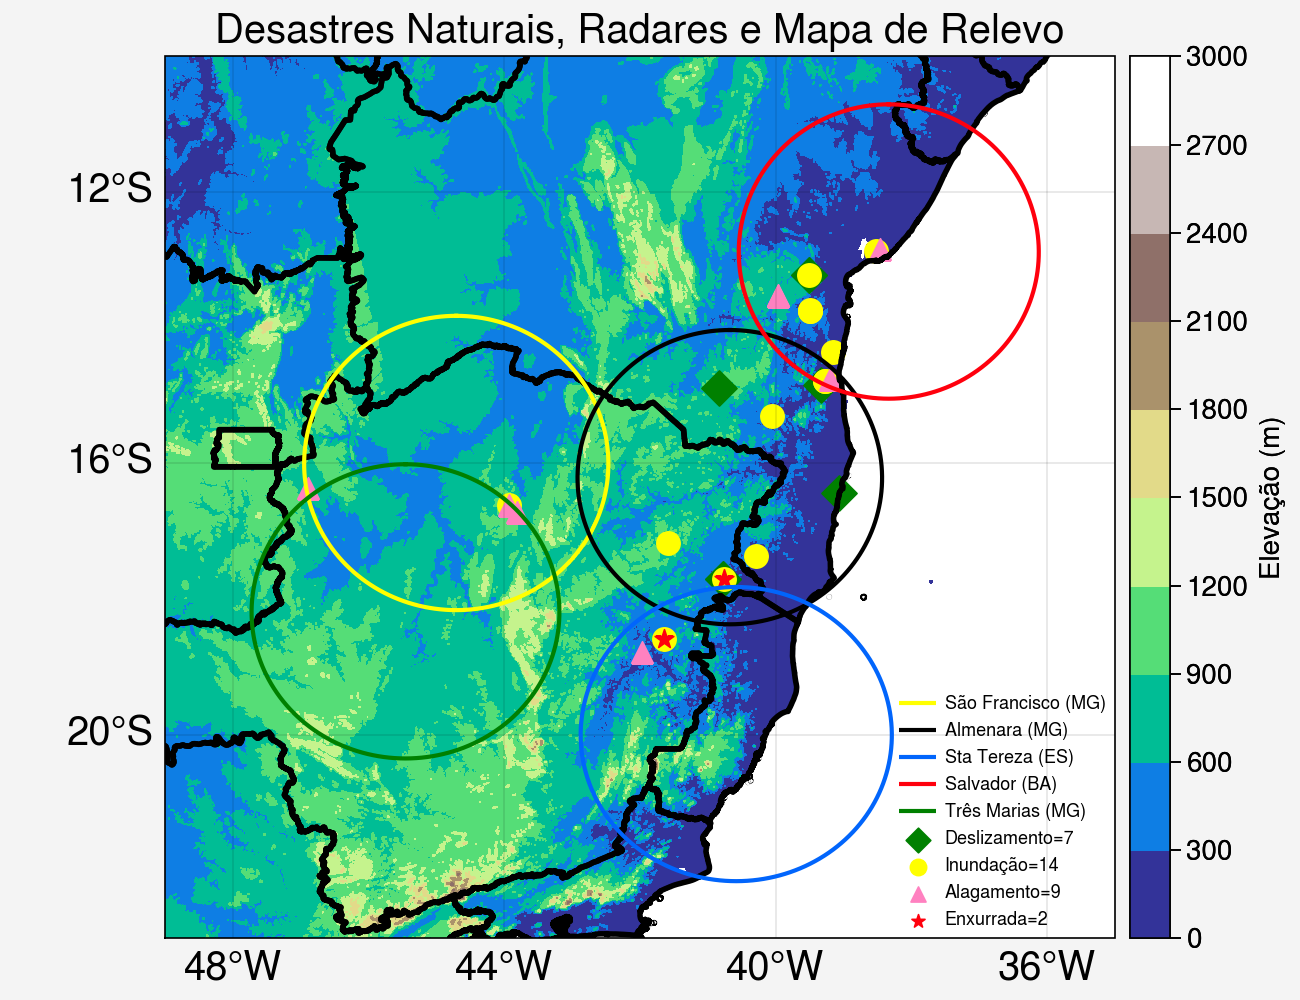

In [16]:
# moldura da figura
fig, ax = pplt.subplots(figsize=(6.5,5), tight=True, proj='pcarree')

# formatação dos eixos da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True,
          latlines=4,
          lonlines=4,
          latlim=(latmin, latmax),
          lonlim=(lonmin, lonmax),
          title=f'Desastres Naturais, Radares e Mapa de Relevo',
          small='20px',
          large='20px')

# plota figura
map1 = ax.contourf(data['x'],
                   data['y'],
                   data[0,:,:],
                   cmap='terrain',
                   vmin=0)

# plota shapefiles
evm_plot_states('/content/BR_UF_2019.shp', 'black', 2.0)

# plota os aneis de distância do radar
evm_plota_aneis_em_geral([240], lon_radar_saofrancisco, lat_radar_saofrancisco, 'yellow', label='São Francisco (MG)')
evm_plota_aneis_em_geral([240], lon_radar_almenara, lat_radar_almenara, 'black', label='Almenara (MG)')
evm_plota_aneis_em_geral([240], lon_radar_statereza, lat_radar_statereza, 'bright blue', label='Sta Tereza (ES)')
evm_plota_aneis_em_geral([240], lon_radar_salvador, lat_radar_salvador, 'bright red', label='Salvador (BA)')
evm_plota_aneis_em_geral([240], lon_radar_tresmarias, lat_radar_tresmarias, 'green', label='Três Marias (MG)')

# plota desastres
for desastre, simbolo, cor, size in zip(desastres, simbols_desastres, colors_desastres, size_desastres):

    # seleciona apenas aquele desastre
    dfx = df[ df['tipo'] == desastre ]

    # plota desastre
    ax.scatter(dfx['lon'].values,
               dfx['lat'].values,
               transform=ccrs.PlateCarree(),
               marker=simbolo,
               s=size,
               color=cor,
               label=f'{desastre}={dfx.shape[0]}')

# plota barra de cores da figura
fig.colorbar(map1, loc='right', label='Elevação (m)', ticklabelsize=10, labelsize=10, space=-6.0)

# adiciona legenda
ax.legend(loc='lr',
          ncols=1,
          frameon=False,
          prop={'size':6.5},
          markerscale=0.7)

# salva figura
fig.save('Figura_relevo_radar.png',
         bbbox_inches='tight',
         dpi=300,
         edgecolor="white")

# exibe na tela
pplt.show()